**Check That GPU installed and Connect drive for weights backup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Feb  9 17:28:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Define helper functions

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

def correct_name(string):
    string = string.split()
    classname = [f"{string[0]}_{string[1]} "]
    coords = [f'{x} ' for x in string[2:]]
    bbox = ''.join(classname + coords) + '\n'
    return bbox

def rewrite_annotations(current_dir):
    for filename in os.listdir(current_dir):
        with open(os.path.join(current_dir, filename), 'r') as f:
            out_string = ''.join([correct_name(string) for string in f.readlines()])
            with open(os.path.join(current_dir, filename), 'w') as fw:
                fw.write(out_string)

import os
import tqdm.notebook

def create_darknet_annotations(path, dir, write_dir):
    '''
    Arguments: 

    path : str : path to annotation file
    dir : str : path to directory. with image
    write_dir : str : path to directory which 
                u want to write in annotations
    
    Returns: 
    
    Path to annotation file
    '''
    filenames = os.listdir(dir)
    img_filenames = ['./'+os.path.join(write_dir, filename) + '\n' for filename in tqdm.notebook.tqdm(list(filenames), total = len(filenames))
                     if filename.endswith('.jpg')]
    with open(path, 'w') as af:
        af.write(''.join(img_filenames))

def create_config_files(
                    dir, 
                    classnames, 
                    backup_path,
                    ):
    '''
    Arguments:

    dir : str : directory to write config files

    Returns:

    output directory
    '''

    if not os.path.isdir(backup_path):
        os.mkdir(backup_path)

    names_file = os.path.join(dir, 'obj.names')
    data_file = os.path.join(dir, 'obj.data')
    train_path = os.path.join(dir, 'train.txt')
    valid_path = os.path.join(dir, 'test.txt')

    with open(names_file, 'w') as fn:
        fn.write(''.join(classname + '\n' for classname in classnames))
    
    with open(data_file, 'w') as fd:
        fd.write(f'classes = {len(classnames)}\ntrain = {train_path}\nvalid = {valid_path}\nnames = {names_file}\nbackup = {backup_path}')
    
    return dir

#Download dataset from OID

In [ ]:
!git clone https://github.com/theAIGuysCode/OIDv4_ToolKit.git
%cd OIDv4_ToolKit
!pip install -r requirements.txt

In [ ]:
!python main.py downloader --classes 'Traffic_light' 'Traffic_sign' --type_csv train --limit 1500 --multiclasses 1

In [ ]:
!python main.py downloader --classes Traffic_light Traffic_sign --type_csv validation --limit 500 --multiclasses 1

In [ ]:
os.rename('./OID/Dataset/train/Traffic light_Traffic sign',
          './OID/Dataset/train/Traffic_light_Traffic_sign')

os.rename('./OID/Dataset/validation/Traffic light_Traffic sign',
          './OID/Dataset/validation/Traffic_light_Traffic_sign')

In [ ]:
with open('./classes.txt', 'w') as f:
    f.write('Traffic_light\nTraffic_sign')

In [ ]:
train_dir = './OID/Dataset/train/Traffic_light_Traffic_sign/Label'
val_dir = './OID/Dataset/validation/Traffic_light_Traffic_sign/Label'

In [ ]:
rewrite_annotations(train_dir)
rewrite_annotations(val_dir)

In [ ]:
!python convert_annotations.py

In [ ]:
create_darknet_annotations(path = './train.txt', 
                           dir = './train',
                           write_dir = 'yolov4/train'
                           )
create_darknet_annotations(path = './test.txt', 
                           dir = './test',
                           write_dir = 'yolov4/test'
                           )

In [ ]:
create_config_files(
                dir = '/content/darknet/yolov4', 
                classnames = ['Traffic light', 'Traffic sign'], 
                backup_path = '/content/drive/MyDrive/NTO/weights/YOLO',
                )

In [ ]:
%cd ..

#Darknet installation

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 13.12 MiB/s, done.
Resolving deltas: 100% (10352/10352), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

#Download dataset from Roboflow and prepare configuration files

In [ ]:
!mkdir ./yolov4
%cd ./yolov4
!curl -L "https://app.roboflow.com/ds/vs91R8q0dR?key=yTHx1rXNSR" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
cat ./train/_darknet.labels

crosswalk
green_light
parking
red_light
stop
yellow_light

In [ ]:
create_darknet_annotations(path = './train.txt', 
                           dir = './train',
                           write_dir = 'yolov4/train'
                           )
create_darknet_annotations(path = './test.txt', 
                           dir = './test',
                           write_dir = 'yolov4/test'
                           )

In [ ]:
create_config_files(
                dir = '/content/darknet/yolov4', 
                classnames = ['crosswalk',
                                'green_light',
                                'parking',
                                'red_light',
                                'stop',
                                'yellow_light'], 
                backup_path = '/content/drive/MyDrive/NTO/weights/YOLO',
                )

'/content/darknet/yolov4'

In [ ]:
!cp /content/darknet/cfg/yolov4-tiny.cfg ./

In [ ]:
!ls

obj.data   README.dataset.txt	test	  train      yolov4-tiny.cfg
obj.names  README.roboflow.txt	test.txt  train.txt  yolov4-tiny.conv.29


In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
%cd ..

# How to Train Your Own YOLOv4 Custom Object Detector!
Now comes the time to create your own custom YOLOv4 object detector to recognize any classes/objects you want!

This requires a couple tricks and tips so make sure to follow along closely with the rest of the tutorial.

In order to create a custom YOLOv4 detector we will need the following:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)

#### Training Dataset
I ran the following commands within the toolkit to create my custom training dataset. I chose to use 1500 images within my dataset but the general rule is the more images the better for higher accuracy of your model. 
```
python main.py downloader --classes 'Vehicle registration plate' --type_csv train --limit 1500
```
**Note: If you are training a detector for multiple classes add '--multiclasses 1' to the command above to have all your training images saved together in one folder.**

This creates a folder with 1500 images of 'Vehicle registration plates' (license plates) for us to train our custom object detector with.

#### Validation Dataset
**Note:** Having a validation dataset is optional but highly recommended.

We want to have a validation dataset in order to properly test our custom object detector after it is trained. We can take advantage of the OIDv4_Toolkit as it has seperate images for validation to make sure we have different images and not ones that are in our training dataset.

We can run the same commands above but for validation. I recommend having a validation dataset size that is roughly 20-30% of your training dataset size.
Since I chose 1500 images for my training data this means I will have a validation size of 300 images. (20% of 1500 = 300)

```
python main.py downloader --classes 'Vehicle registration plate' --type_csv validation --limit 300
```
#### Now you have a proper validation dataset to test your custom object detector after training!


# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg, obj.data, obj.names, train.txt and test.txt files.

It is important to configure all these files with extreme caution as typos or small errors can cause major problems with your custom training.

## i) Cfg File
Copy over the yolov4.cfg to your Google Drive by running the cell below. This will allow us to edit it in a text editor.


I set my **max_batches = 6000**, **steps = 4800, 5400**, I changed the **classes = 1** in the three YOLO layers and **filters = 18** in the three convolutional layers before the YOLO layers.

How to Configure Your Variables:

width = 416

height = 416
**(these can be any multiple of 32)**

max_batches = (# of classes) * 2000
**(but no less than 6000 

steps = (80% of max_batches), (90% of max_batches)

filters = (# of classes + 5) * 3



## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** where you will have one class name per line in the same order as your classes.txt from the dataset generation step.

**NOTE:** You do not want to have spaces in your class name. For this reason I changed "Vehicle Registration Plate" to **license_plate**.

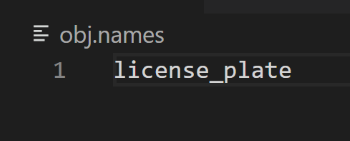

Example for multiclass obj.names file:

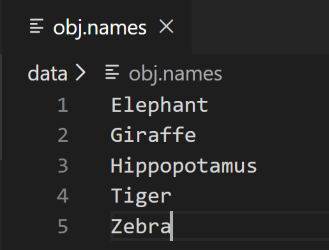

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

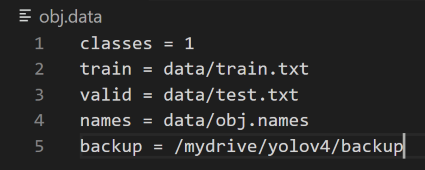

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv4 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. USE IT!



```
!./darknet detector train <path to obj.data> <path to custom config> <path to weights> -dont_show -map
```





```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```



In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
!./darknet detector train  \
                    ./yolov4/obj.data \
                    ./yolov4/yolov4-tiny.cfg \
                    ./yolov4/yolov4-tiny.conv.29 \
                    -dont_show -map

After training, you can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you should aim for a loss under 2.

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

# Step 7: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [ ]:
%cd ..

/content/darknet


 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	    

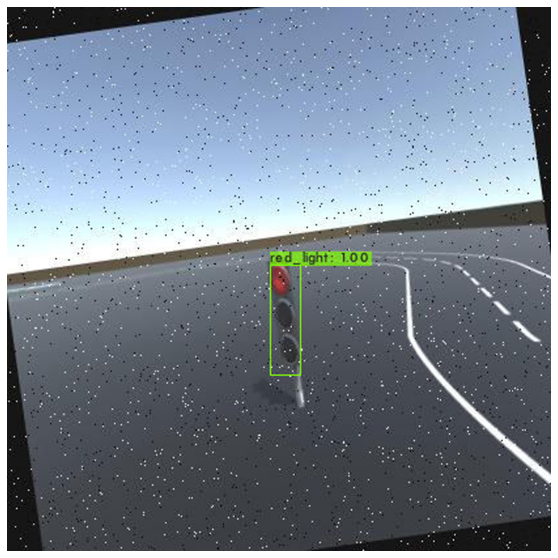

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test \
                        ./yolov4/obj.data \
                        ./yolov4/yolov4-tiny.cfg  \
                        /content/drive/MyDrive/NTO/weights/YOLO/yolov4-tiny_best.weights \
                        ./yolov4/train/0_jpg.rf.17c258a77f845705171dc523f74dcf16.jpg
imShow('predictions.jpg')